# Text Mining

### Q2) a.Extract reviews of any product from ecommerce website like amazon
###        b. Perform emotion mining

# ANSWER:

Here, I download the  mobile data reviews from amazon to do the emotional mining.

In [1]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importing all required library
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline

from bs4 import BeautifulSoup  
import re # regular expression
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag

import logging
from gensim.models import word2vec
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from collections import defaultdict
from keras.layers.convolutional import Convolution1D
from keras import backend as K
from keras.layers.embeddings import Embedding


C:\Users\91830\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
# Load csv file
df = pd.read_csv('Amazon_Unlocked_Mobile.csv')
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0


In [4]:
print("Summary statistics of numerical features : \n", df.describe())

print("\nTotal number of reviews: ",len(df))
print("\nTotal number of brands: ", len(list(set(df['Brand Name']))))
print("\nTotal number of unique products: ", len(list(set(df['Product Name']))))

print("\nPercentage of reviews with neutral sentiment : {:.2f}%"\
      .format(df[df['Rating']==3]["Reviews"].count()/len(df)*100))
print("\nPercentage of reviews with positive sentiment : {:.2f}%"\
      .format(df[df['Rating']>3]["Reviews"].count()/len(df)*100))
print("\nPercentage of reviews with negative sentiment : {:.2f}%"\
      .format(df[df['Rating']<3]["Reviews"].count()/len(df)*100))

Summary statistics of numerical features : 
             Price      Rating  Review Votes
count  400.000000  400.000000    400.000000
mean   115.381000    3.637500      1.440000
std    102.985965    1.551487      3.362241
min     17.950000    1.000000      0.000000
25%     23.900000    2.000000      0.000000
50%     69.990000    4.000000      0.000000
75%    199.990000    5.000000      1.000000
max    299.000000    5.000000     24.000000

Total number of reviews:  400

Total number of brands:  10

Total number of unique products:  16

Percentage of reviews with neutral sentiment : 11.25%

Percentage of reviews with positive sentiment : 61.25%

Percentage of reviews with negative sentiment : 27.50%


Text(0, 0.5, 'Count')

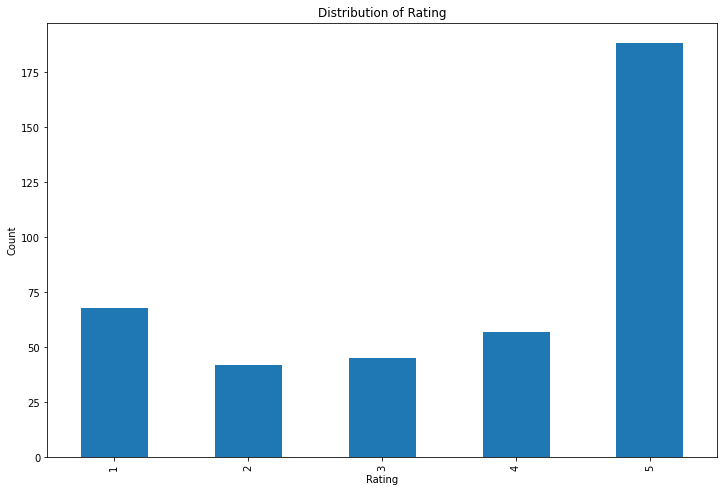

In [5]:
# Plot distribution of rating
plt.figure(figsize=(12,8))
# sns.countplot(df['Rating'])
df['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

Text(0.5, 1.0, 'Number of Reviews for Top 20 Brands')

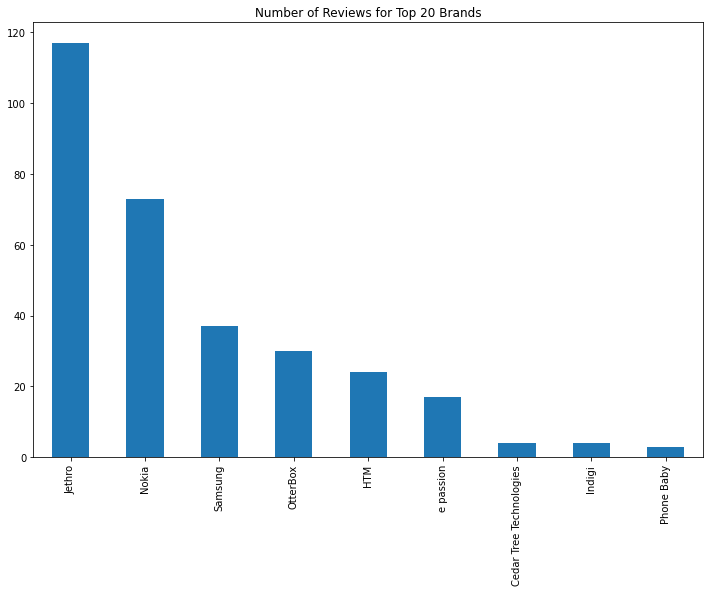

In [6]:
# Plot number of reviews for top 20 brands
brands = df["Brand Name"].value_counts()
# brands.count()
plt.figure(figsize=(12,8))
brands[:20].plot(kind='bar')
plt.title("Number of Reviews for Top 20 Brands")

Text(0.5, 1.0, 'Number of Reviews for Top 50 Products')

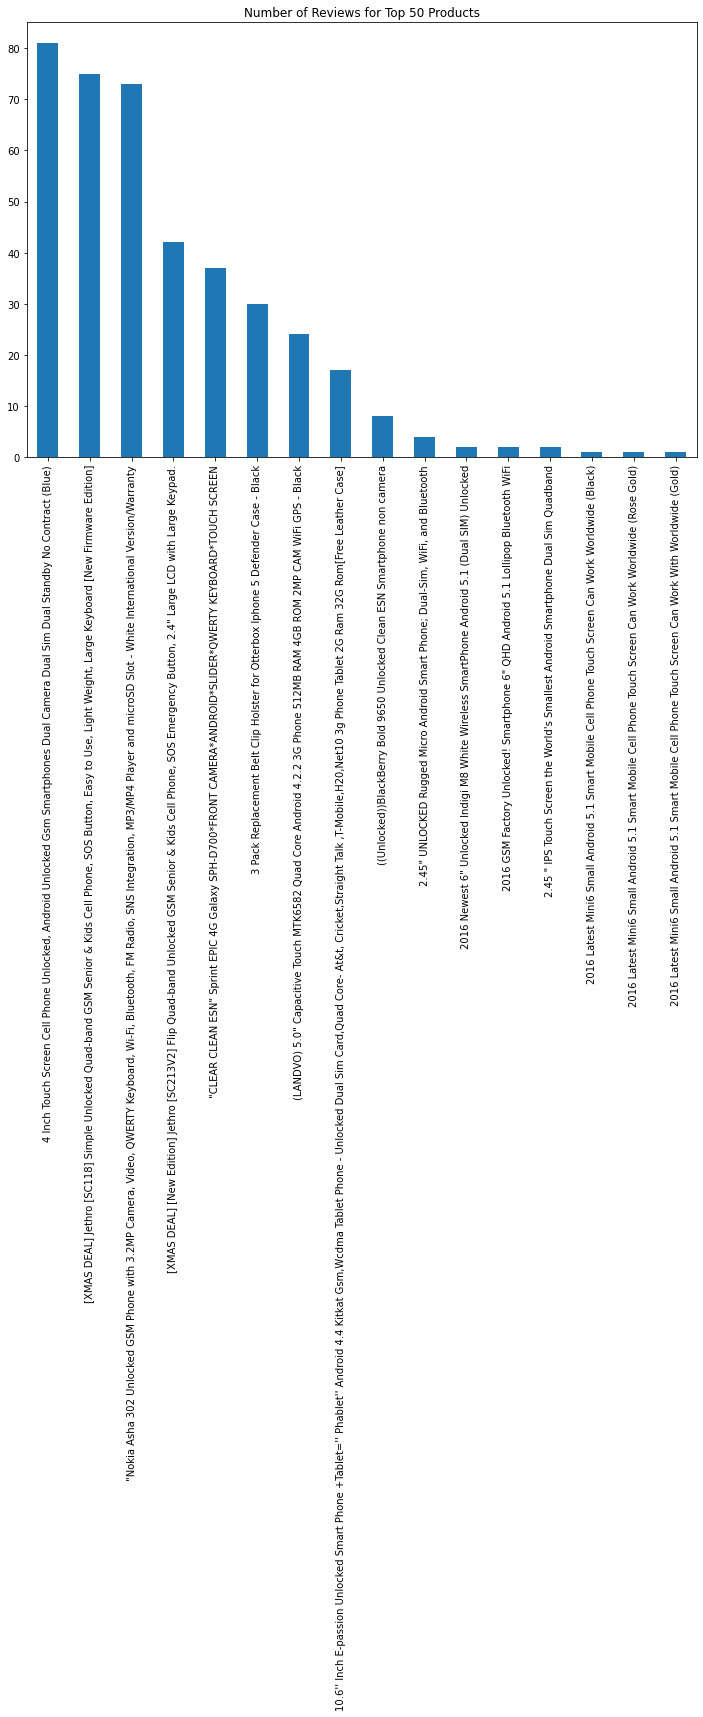

In [7]:
# Plot number of reviews for top 50 products
products = df["Product Name"].value_counts()
plt.figure(figsize=(12,8))
products[:50].plot(kind='bar')
plt.title("Number of Reviews for Top 50 Products")

Text(0, 0.5, 'Count')

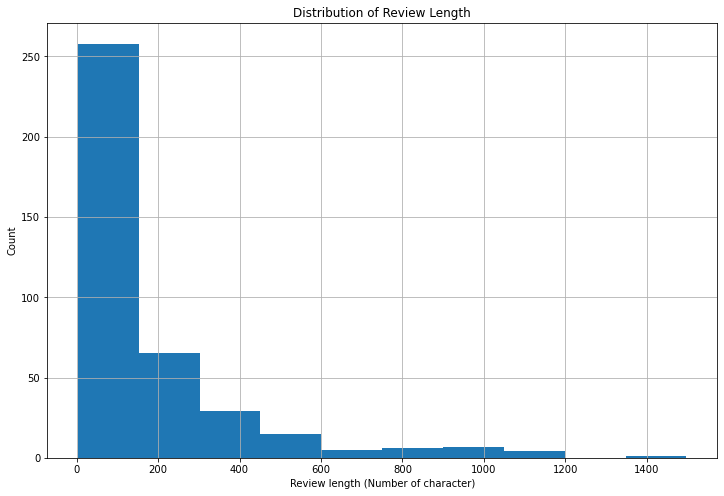

In [8]:
# Plot distribution of review length
review_length = df["Reviews"].dropna().map(lambda x: len(x))
plt.figure(figsize=(12,8))
review_length.loc[review_length < 1500].hist()
plt.title("Distribution of Review Length")
plt.xlabel('Review length (Number of character)')
plt.ylabel('Count')

### Data Preparaation

In [9]:
df = df.sample(frac=0.1, random_state=0) #uncomment to use full set of data

# Drop missing values
df.dropna(inplace=True)

# Remove any 'neutral' ratings equal to 3
df = df[df['Rating'] != 3]

# Encode 4s and 5s as 1 (positive sentiment) and 1s and 2s as 0 (negative sentiment)
df['Sentiment'] = np.where(df['Rating'] > 3, 1, 0)
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Sentiment
132,"(LANDVO) 5.0"" Capacitive Touch MTK6582 Quad Co...",HTM,69.99,5,Cheap and fast,0,1
309,3 Pack Replacement Belt Clip Holster for Otter...,OtterBox,17.95,4,Order these every 6 months for my husbands pho...,0,1
196,[XMAS DEAL] Jethro [SC118] Simple Unlocked Qua...,Jethro,59.99,2,"Not good sound, not easily used by senior, end...",0,0
60,"""Nokia Asha 302 Unlocked GSM Phone with 3.2MP ...",Nokia,299.00,5,Excelente,0,1
155,[XMAS DEAL] [New Edition] Jethro [SC213V2] Fli...,Jethro,79.99,4,Nice phone. Easy to read screen. I am a senior...,6,1


In [10]:
df.Rating

132    5
309    4
196    2
60     5
155    4
261    5
141    5
214    4
37     5
134    5
12     5
59     5
293    5
140    4
206    5
199    1
176    1
268    4
124    4
313    5
78     5
15     2
286    5
102    5
170    5
303    5
225    1
65     5
76     2
90     1
173    5
179    2
Name: Rating, dtype: int64

### Splitting of the data into train test

In [11]:
# Split data into training set and validation
X_train, X_test, y_train, y_test = train_test_split(df['Reviews'], df['Sentiment'], \
                                                    test_size=0.1, random_state=0)

print('Load %d training examples and %d validation examples. \n' %(X_train.shape[0],X_test.shape[0]))
print('Show a review in the training set : \n', X_train.iloc[10])

Load 28 training examples and 4 validation examples. 

Show a review in the training set : 
 Bought for my mom! She loves it!


### Text Preprocessing

In [12]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words))

In [13]:
# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n',  X_train_cleaned[10])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))

Show a cleaned review in the training set : 
 bought for my mom she loves it


### CountVectorizer with Mulinomial Naive Bayes (Benchmark Model)

In [14]:
# Fit and transform the training data to a document-term matrix using CountVectorizer
countVect = CountVectorizer() 
X_train_countVect = countVect.fit_transform(X_train_cleaned)
print("Number of features : %d \n" %len(countVect.get_feature_names())) #6378 
print("Show some feature names : \n", countVect.get_feature_names()[::1000])


# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train_countVect, y_train)

Number of features : 503 

Show some feature names : 
 ['able']


MultinomialNB()

In [15]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

In [16]:
# Evaluate the model on validaton set
predictions = mnb.predict(countVect.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.7500

AUC score : 0.5000

Classification report : 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.75      1.00      0.86         3

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4


Confusion Matrix : 
 [[0 1]
 [0 3]]


C:\Users\91830\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### TfidfVectorizer with Logistic Regression

In [17]:
# Fit and transform the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names())) #1722
print("Show some feature names : \n", tfidf.get_feature_names()[::1000])

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

Number of features : 26 

Show some feature names : 
 ['and']


LogisticRegression()

In [18]:
# Look at the top 10 features with smallest and the largest coefficients
feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with smallest coefficients :
['not' 'it' 'is' 'on' 'that' 'was' 'this' 'have' 'but' 'the']

Top 10 features with largest coefficients : 
['good' 'for' 'my' 'use' 'and' 'so' 'no' 'in' 'to' 'bought']


In [19]:
# Evaluate on the validaton set
predictions = lr.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.7500

AUC score : 0.5000

Classification report : 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.75      1.00      0.86         3

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4


Confusion Matrix : 
 [[0 1]
 [0 3]]


C:\Users\91830\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Pipeline and GridSearch

In [20]:
# Building a pipeline
estimators = [("tfidf", TfidfVectorizer()), ("lr", LogisticRegression())]
model = Pipeline(estimators)


# Grid search
params = {"lr__C":[0.1, 1, 10], #regularization param of logistic regression
          "tfidf__min_df": [1, 3], #min count of words 
          "tfidf__max_features": [1000, None], #max features
          "tfidf__ngram_range": [(1,1), (1,2)], #1-grams or 2-grams
          "tfidf__stop_words": [None, "english"]} #use stopwords or don't

grid = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_cleaned, y_train)
print("The best paramenter set is : \n", grid.best_params_)


# Evaluate on the validaton set
predictions = grid.predict(X_test_cleaned)
modelEvaluation(predictions)

The best paramenter set is : 
 {'lr__C': 10, 'tfidf__max_features': 1000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None}

Accuracy on validation set: 0.7500

AUC score : 0.5000

Classification report : 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.75      1.00      0.86         3

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4


Confusion Matrix : 
 [[0 1]
 [0 3]]


C:\Users\91830\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Parsing Review into Sentences

In [21]:
# Split review text into parsed sentences uisng NLTK's punkt tokenizer
# nltk.download()
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def parseSent(review, tokenizer, remove_stopwords=False):
    '''
    Parse text into sentences
    '''
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(cleanText(raw_sentence, remove_stopwords, split_text=True))
    return sentences


# Parse each review in the training set into sentences
sentences = []
for review in X_train_cleaned:
    sentences += parseSent(review, tokenizer)
    
print('%d parsed sentence in the training set\n'  %len(sentences))
print('Show a parsed sentence in the training set : \n',  sentences[10])


28 parsed sentence in the training set

Show a parsed sentence in the training set : 
 ['bought', 'for', 'my', 'mom', 'she', 'loves', 'it']


### WorldCloud

In [38]:
string_Total = " ".join(df["Reviews"])

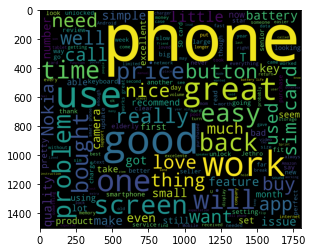

In [39]:
#wordcloud for entire corpus
from wordcloud import WordCloud
wordcloud_stw = WordCloud(
                background_color= 'black',
                width = 1800,
                height = 1500
                ).generate(string_Total)
plt.imshow(wordcloud_stw)

## OR it may be solve as

In [25]:
# Importing all required library
import re # regular expression
import nltk #The Natural Language Toolkit
import tweepy #very convenient way to access the Twitter API with Python.
import string # special operations on strings
import spacy # language models

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [26]:
# Load csv file
df = pd.read_csv('Amazon_Unlocked_Mobile.csv')
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0


In [27]:
# let's calculate subjectivity and Polarity
# function for subjectivity
def calc_subj(Reviews):
    return TextBlob(Reviews).sentiment.subjectivity
 
# function for Polarity
def calc_pola(Reviews):
    return TextBlob(Reviews).sentiment.polarity
 
df['Subjectivity'] = df.Reviews.apply(calc_subj)
df['Polarity'] = df.Reviews.apply(calc_pola)

In [28]:
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Subjectivity,Polarity
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1,0.611000,0.180952
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0,0.762222,0.449259
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0,1.000000,0.650000
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0,0.595000,0.452500
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0,0.708333,0.214583


In [29]:
#Now let's classify these tweets based on their sentiment(polarity)
def sentiment(ploarity):
    result= ''
    if ploarity > 0:
        result = 'Positive'
    elif ploarity == 0:
        result = 'Neutral'
    else:
        result = 'Negative'
    return result

df['Sentiment'] = df.Polarity.apply(sentiment)
        

In [30]:
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Subjectivity,Polarity,Sentiment
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1,0.611000,0.180952,Positive
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0,0.762222,0.449259,Positive
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0,1.000000,0.650000,Positive
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0,0.595000,0.452500,Positive
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0,0.708333,0.214583,Positive


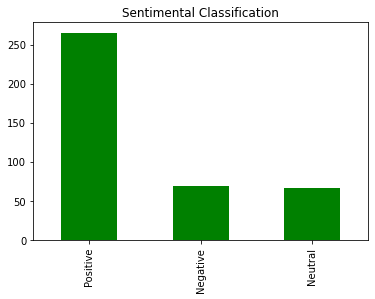

In [31]:
#Let's see how many ratio of sentiment
df.Sentiment.value_counts().plot(kind='bar',color='green')
plt.title('Sentimental Classification')
plt.show()

Text(0, 0.5, 'Subjectivity')

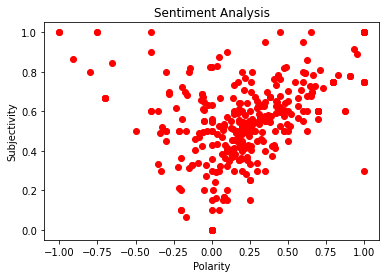

In [32]:
#To Draw Scatter plot
plt.scatter(df.Polarity, df.Subjectivity, color='red')
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

In [33]:
# let's see the percentage of different sentiment's class
 
# Creat
Df_sentiment = pd.DataFrame(df.Sentiment.value_counts(normalize=True)*100)
 
# calculating percentage
Df_sentiment['Total'] = df.Sentiment.value_counts()


In [40]:
#Calculating sentiment's
Df_sentiment

,Sentiment,Total
Positive,66.25,265
Negative,17.25,69
Neutral,16.50,66


### WorldCloud

In [36]:
string_Total = " ".join(df["Reviews"])

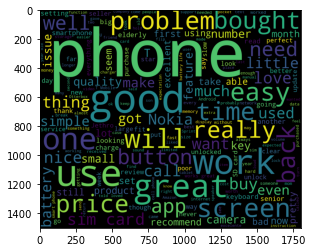

In [37]:
#wordcloud for entire corpus
from wordcloud import WordCloud
wordcloud_stw = WordCloud(
                background_color= 'black',
                width = 1800,
                height = 1500
                ).generate(string_Total)
plt.imshow(wordcloud_stw)